## Task 1. Merge Data Function

In [1]:
import pandas as pd
import json

def __merge(customer_filename: str, transaction_filename: str, fraud_filename: str) -> pd.DataFrame:
    """
    Merges customer, transaction, and fraud data sources into a single DataFrame.
    
    Parameters:
    - customer_filename: str - Path to the customer data CSV file
    - transaction_filename: str - Path to the transaction data Parquet file
    - fraud_filename: str - Path to the fraud data JSON file
    
    Returns:
    - pd.DataFrame - Merged and sorted DataFrame
    """
    # Load data for customer and transaction
    customer_data = pd.read_csv(customer_filename)
    transaction_data = pd.read_parquet(transaction_filename)

    # Reset index to make 'trans_num' a column
    transaction_data.reset_index(inplace=True)
    
    with open('securebank/data_sources/fraud_release.json') as f:
        fraud_data = json.load(f)

    # Convert the dictionary to a DataFrame
    fraud_df = pd.DataFrame(list(fraud_data.items()), columns=['trans_num', 'is_fraud'])

    # Handle null values (assuming null means non-fraudulent, could be replaced with 0)
    fraud_df['is_fraud'].fillna(0, inplace=True)

    # Convert 'is_fraud' to integer for consistency
    fraud_df['is_fraud'] = fraud_df['is_fraud'].astype(int)

    # Convert 'trans_num' to string type in both DataFrames for consistent merging
    fraud_df['trans_num'] = fraud_df['trans_num'].astype(str)
    
    # Merge dataframes on 'cc_num' and 'trans_num'
    merged_data = transaction_data.merge(customer_data, on='cc_num')
    merged_data = merged_data.merge(fraud_df, on='trans_num')
    
    # Sort by transaction date and time
    merged_data.sort_values(by='trans_date_trans_time', inplace=True)
    
    return merged_data

# Example usage
customer_filename = 'securebank/data_sources/customer_release.csv'
transaction_filename = 'securebank/data_sources/transactions_release.parquet'
fraud_filename = 'securebank/data_sources/fraud_release.json'

merged_df = __merge(customer_filename, transaction_filename, fraud_filename)
merged_df.head()

,trans_num,index_x,trans_date_trans_time,cc_num,unix_time,merchant,category,amt,merch_lat,merch_long,...,street,city,state,zip,lat,long,city_pop,job,dob,is_fraud
1368456,0b242abb623afc578575680df30655b9,0,2019-01-01 00:00:18,2703186189652095,1.325376e+09,None,MISC_NET,4.97,36.011293,-82.048315,...,561 Perry Cove,Moravian Falls,NC,28654.0,36.0788,-81.1781,3495.0,"PSYCHOLOGIST, COUNSELLING","Mar 09, 1988",0
291276,1f76529f8574734946361c461b024d99,1,2019-01-01 00:00:44,630423337322,1.325376e+09,None,GROCERY_POS,107.23,49.159047,-118.186462,...,43039 Riley Greens Suite 393,Orient,WA,99160.0,48.8878,-118.2105,149.0,Special educational needs teacher,21-Jun-1978,0
1539297,a1a22d70485983eac12b5b88dad1cf95,2,2019-01-01 00:00:51,38859492057661,1.325376e+09,fraud_Lind-Buckridge,entertainment,220.11,43.150704,-112.154481,...,594 White Dale Suite 530,Malad City,ID,83252.0,42.1808,-112.2620,4154.0,Nature conservation officer,19-Jan-1962,0
1505439,6b849c168bdad6f867558c3793159a81,3,2019-01-01 00:01:16,3534093764340240,1.325376e+09,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,47.034331,-112.561071,...,9443 Cynthia Court Apt. 038,Boulder,MT,59632.0,46.2306,-112.1138,1939.0,Patent attorney,12-Jan-1967,0
571750,a41d7549acf90789359a9aa5346dcb46,4,2019-01-01 00:03:06,375534208663984,1.325376e+09,fraud_Keeling-Crist,MISC_POS,41.96,38.674999,-78.632459,...,408 Bradley Rest,Doe Hill,VA,24433.0,38.4207,-79.4629,99.0,DANCE MOVEMENT PSYCHOTHERAPIST,28/03/1986,0


## Task 2: Data Analytics

### Analyze Insight #1: Fraud Frequency by Hour of Day

<Axes: title={'center': 'Fraud Frequency by Hour of Day'}>

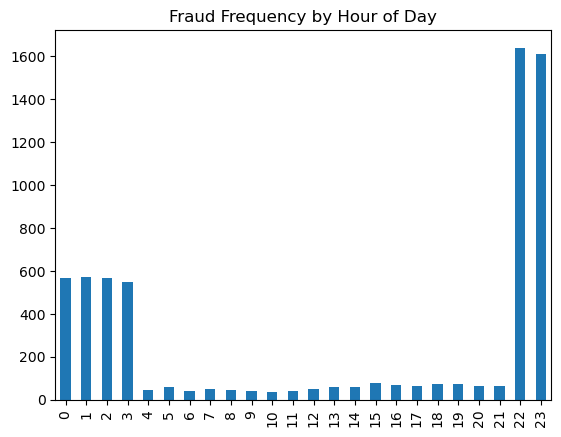

In [2]:
# Extract hour from transaction date-time
merged_df['hour_of_day'] = pd.to_datetime(merged_df['trans_date_trans_time']).dt.hour

# Plot fraud frequency by hour
hourly_fraud = merged_df[merged_df['is_fraud'] == 1]['hour_of_day'].value_counts().sort_index()
hourly_fraud.plot(kind='bar', title='Fraud Frequency by Hour of Day')

The frequency of fraudulent transactions does seem to depend on the hour of the day. Transactions are high early in the morning, likely before most people or bank employees are awake. Transactions are even higher late at night, perhaps as most people are going to sleep.

### Analyze Insight #2: Fraud Frequency by Day of Week

<Axes: title={'center': 'Fraud Frequency by Day of Week'}>

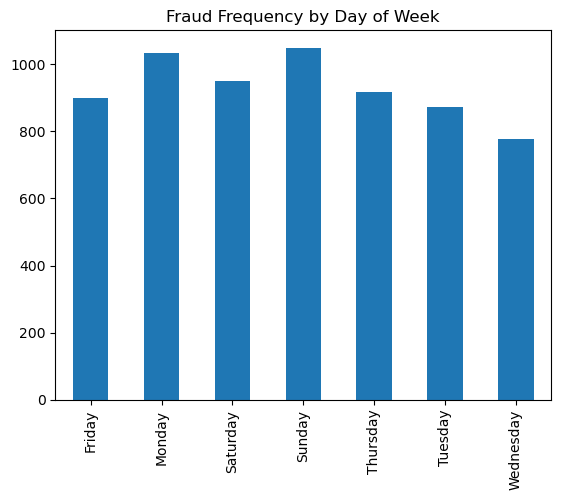

In [3]:
# Extract day of week from transaction date-time
merged_df['day_of_week'] = pd.to_datetime(merged_df['trans_date_trans_time']).dt.day_name()

# Plot fraud frequency by day of week
daily_fraud = merged_df[merged_df['is_fraud'] == 1]['day_of_week'].value_counts().sort_index()
daily_fraud.plot(kind='bar', title='Fraud Frequency by Day of Week')

Fraud frequency seems to be evenly distributed throughout the week. The graph above shows it to be slightly higher on Mondays and Sundays, but the fraud frequency never differs by more than 200 day by day.

### Analyze Insight #3: Fraud Frequency by Month

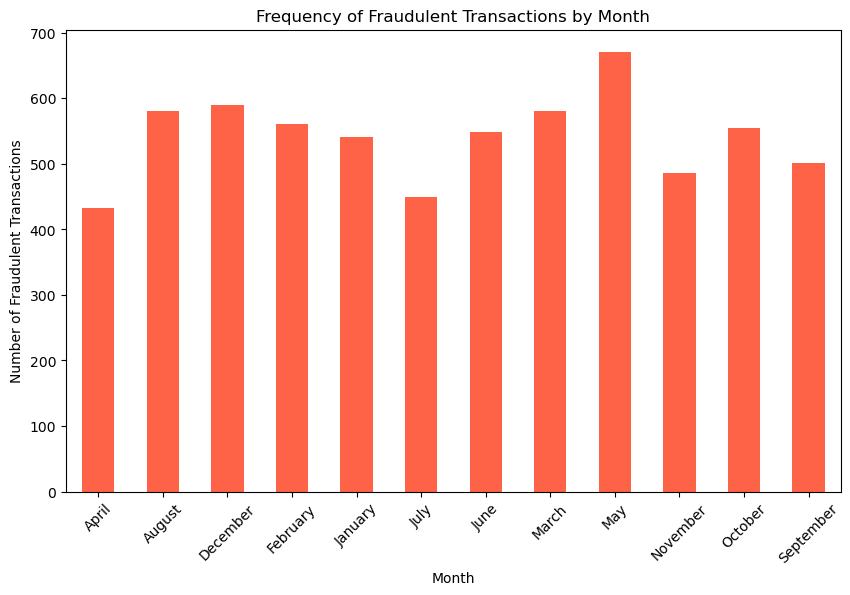

In [5]:
import matplotlib.pyplot as plt

# Convert 'trans_date_trans_time' to datetime format
merged_df['trans_date_trans_time'] = pd.to_datetime(merged_df['trans_date_trans_time'])

# Extract the month from the transaction date
merged_df['transaction_month'] = merged_df['trans_date_trans_time'].dt.month_name()

# Calculate the number of fraudulent transactions per month
monthly_fraud_count = merged_df[merged_df['is_fraud'] == 1]['transaction_month'].value_counts().sort_index()

# Visualize the frequency of fraudulent transactions by month
plt.figure(figsize=(10, 6))
monthly_fraud_count.plot(kind='bar', color='tomato')
plt.title('Frequency of Fraudulent Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.show()

The frequency of fraudulent transactions seem to be relatively low in April, spike in May, then come down in the month of June and July. This may indicate a seasonal pattern in fraudulent activities. For example, fraudsters might target months with high consumer spending, such as during the holiday season.

### Analyze Insight #4: Fraudulent Transactions Occur in Quick Succession

In [9]:
# Filter for fraudulent transactions
fraudulent_transactions = merged_df[merged_df['is_fraud'] == 1].copy()

# Sort transactions by customer and transaction time
fraudulent_transactions.sort_values(by=['cc_num', 'trans_date_trans_time'], inplace=True)

# Calculate time difference between consecutive transactions for each customer
fraudulent_transactions['time_diff'] = fraudulent_transactions.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()

# Display the DataFrame with time differences
print(fraudulent_transactions[['cc_num', 'trans_date_trans_time', 'time_diff']].tail())

                      cc_num trans_date_trans_time  time_diff
1143606  4992346398065154184   2019-10-31 23:55:45      331.0
1144387  4992346398065154184   2019-11-01 02:40:44     9899.0
1143235  4992346398065154184   2019-11-01 14:55:10    44066.0
1143488  4992346398065154184   2019-11-01 22:08:45    26015.0
1143036  4992346398065154184   2019-11-01 22:23:48      903.0


There is no evidence that fraudulent transactions occur in quick successions. The time differences between successive fraudulent transactions seem to range from 300 - 50000 seconds. 

### Insight 1: Fraud Frequency by Merchant Category

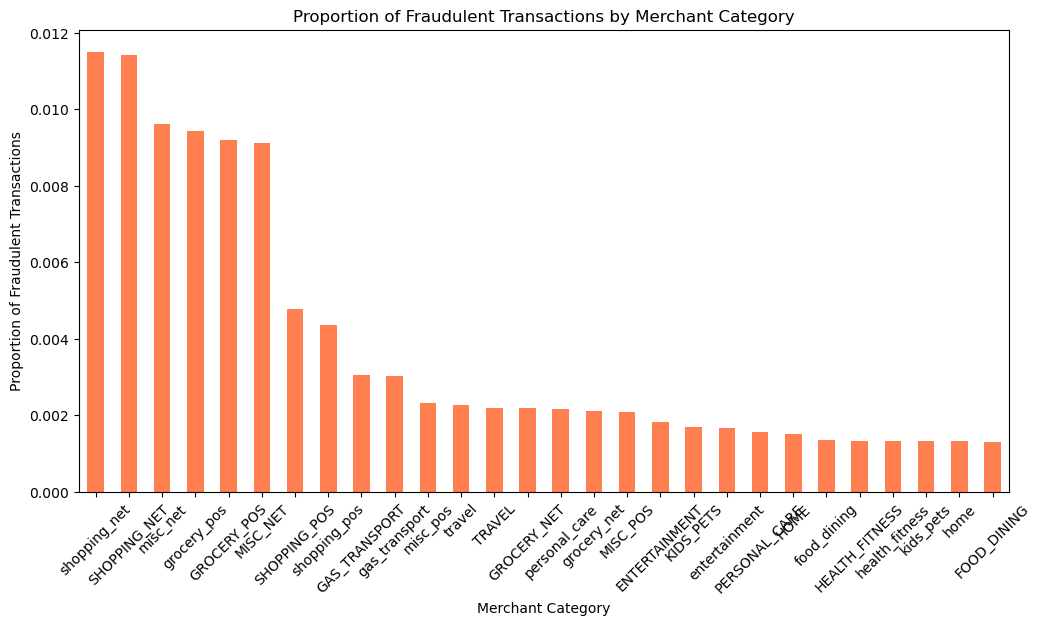

In [7]:
# Group by merchant category and calculate the number of fraudulent transactions
fraud_by_category = merged_df[merged_df['is_fraud'] == 1]['category'].value_counts()
total_by_category = merged_df['category'].value_counts()

# Calculate the proportion of fraudulent transactions in each category
fraud_proportion_by_category = (fraud_by_category / total_by_category).fillna(0)

# Visualize the data
fraud_proportion_by_category.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), color='coral')
plt.title('Proportion of Fraudulent Transactions by Merchant Category')
plt.xlabel('Merchant Category')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.show()

It appears that merchant categories such as shopping_net, misc_net, and grocery_pos have a higher incidence of fraud. This insight can help the bank focus on monitoring high-risk categories.

### Insight 2: Customer Demographic Analysis and Fraud Likelihood

/var/folders/8k/83d15p3d4sq2scn4fwt6hsb40000gn/T/ipykernel_23966/1036532560.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  merged_df['dob'] = pd.to_datetime(merged_df['dob'], errors='coerce')


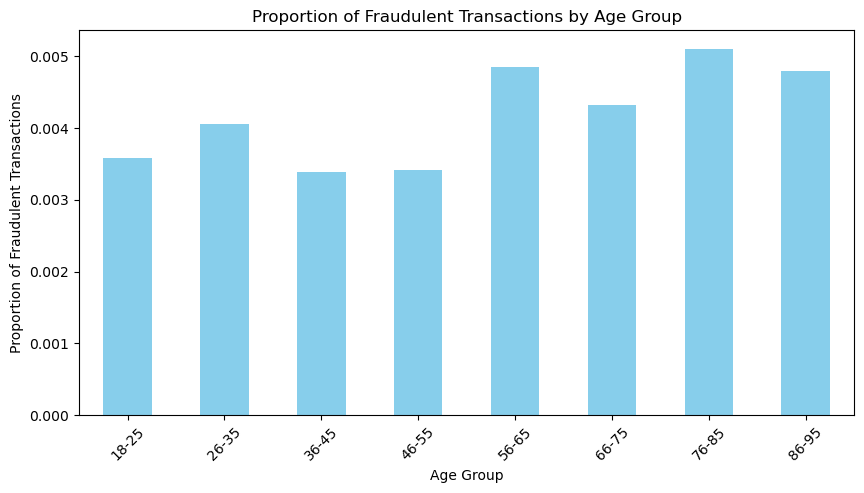

In [8]:
from datetime import datetime

# Convert 'dob' to datetime and calculate age
merged_df['dob'] = pd.to_datetime(merged_df['dob'], errors='coerce')
merged_df['age'] = merged_df['dob'].apply(lambda x: datetime.now().year - x.year if pd.notnull(x) else None)

# Categorize age groups
bins = [18, 25, 35, 45, 55, 65, 75, 85, 95]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95']
merged_df['age_group'] = pd.cut(merged_df['age'], bins=bins, labels=labels)

# Analyze fraud by age group
fraud_by_age_group = merged_df[merged_df['is_fraud'] == 1]['age_group'].value_counts()
total_by_age_group = merged_df['age_group'].value_counts()

# Calculate the proportion of fraudulent transactions by age group
fraud_proportion_by_age_group = (fraud_by_age_group / total_by_age_group).fillna(0)

# Visualize the data
fraud_proportion_by_age_group.sort_index().plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Proportion of Fraudulent Transactions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.show()

It seems that customers of older age groups are more vulnerable to fraudulent transactions. This information can help the bank determine where to focus additional resources in security.